In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

In [2]:
# load age productivity profile and lifetable
age_profile = np.loadtxt('ageprod.txt')
surv_rate = np.loadtxt('surv_rate.txt')
population_weights = np.ones_like(surv_rate)
population_weights[1:] = np.cumprod(surv_rate)[:-1]

In [3]:
# economic parameters
maxage = 81
ret_age = 45
betta = 0.98
sigma = 2.0
rep = 0.3
v_frisch = 0.5
chi = 50.0
alpha = 0.33
delta = 0.08

In [4]:
# retiree to worker ratio
rw_ratio = np.sum(population_weights[ret_age:]) / np.sum(population_weights[:ret_age])
tau = rep * rw_ratio / (1 + rep * rw_ratio)

In [5]:
amin = 0.0
amax = 10.0
na = 101

# set up the savings grid
agrid = np.linspace(amin, amax, na)

In [6]:
def solve_life_cycle(ratio, ben):

    # calculate factor prices depending on capital stock and labor supply guess
    w = (1 - alpha) * ratio ** alpha
    irate = alpha * ratio ** (alpha - 1) - delta

    # pre-allocate
    ap = np.zeros((maxage, na))
    con = np.zeros((maxage, na))
    lab = np.zeros((maxage, na))
    lab_new = np.zeros((maxage, na))
    c_new = np.zeros((maxage, na)) # implied consumption
    astar = np.zeros((maxage, na)) # endogenous asset
    a_bar = np.zeros(maxage) # a today correspodning to a'=0

    # LAST PERIOD
    j = maxage-1
    # loop over (beginning-of-period) savings
    for ia in range(na):
        # the household will consume all the remaining resources
        ap[j, ia] = 0.0
        con[j, ia] = (1.0 + irate) * agrid[ia] + ben

    # RETRIEMENT PERIODS
    # loop backwards over all periods
    for j in range(maxage-2, ret_age-1, -1):

        # EGM Step 1:
        # loop over savings choice
        for ia in range(na):
            # compute the RHS of the euler equation
            rhs = betta * surv_rate[j] * (1.0 + irate) * con[j+1, ia]**(-sigma)
            # compute the implied consumption
            c_new[j, ia] = rhs**(-1.0/sigma)
            # compute the implied beginning-of-period assets
            astar[j, ia] = (c_new[j, ia] + agrid[ia] - ben) / (1.0 + irate)

        # store the savings corresponding to the lowest grid point
        a_bar[j] = astar[j, 0]

        # EGM Step 2:
        # loop over beginning-of-period assets
        for ia in range(na):
            if agrid[ia] < a_bar[j]: # if the borrowing constraint is binding
                con[j, ia] = ben + (1.0 + irate) * agrid[ia]
                ap[j, ia] = 0.0
            else: # if the borrowing cosntraint is not binding
                con[j, ia] = np.interp(agrid[ia], astar[j, :], c_new[j, :])
                ap[j, ia] = (1.0 + irate) * agrid[ia] + ben - con[j, ia]

    # WORKING PERIODS
    # loop backwards over all periods
    for j in range(ret_age-1, -1, -1):

        # EGM Step 1:
        # loop over savings choice
        for ia in range(na):
            # compute the RHS of the euler equation
            rhs = betta * surv_rate[j] * (1.0 + irate) * con[j+1, ia]**(-sigma)
            # compute the implied consumption
            c_new[j, ia] = rhs**(-1.0/sigma)
            # find labor supply
            lab_new[j, ia] = ((c_new[j, ia] ** (-sigma) * (1 - tau) * w * age_profile[j]) / chi) ** v_frisch
            # compute the implied beginning-of-period assets
            astar[j, ia] = (c_new[j, ia] + agrid[ia] - (1 - tau) * w * age_profile[j] * lab_new[j, ia]) / (1.0 + irate)

        # store the savings corresponding to the lowest grid point
        a_bar[j] = astar[j, 0]

        # EGM Step 2:
        # loop over beginning-of-period assets
        for ia in range(na):
            if agrid[ia] < a_bar[j]: # if the borrowing constraint is binding

                # when the constraint is binding the choices for consumption and
                # labor supply are not analytical, therefore we solve the system
                # of equations numerically
                def lab_bc(lab_guess):
                    con_imp = (1 + irate) * agrid[ia] + (1 - tau) * w * age_profile[j] * lab_guess
                    res = chi * lab_guess ** (1 / v_frisch) - (1 - tau) * w * age_profile[j] * con_imp ** (-sigma)
                    return res

                lab[j, ia] = scipy.optimize.brentq(lab_bc, 0.01, 2.0)
                con[j, ia] = (1 - tau) * w * age_profile[j] * lab[j, ia] + (1.0 + irate) * agrid[ia]
                ap[j, ia] = 0.0
            else: # if the borrowing cosntraint is not binding

                con[j, ia] = np.interp(agrid[ia], astar[j, :], c_new[j, :])
                lab[j, ia] = np.interp(agrid[ia], astar[j, :], lab_new[j, :])
                ap[j, ia] = (1.0 + irate) * agrid[ia] + (1 - tau) * w * age_profile[j] * lab[j, ia] - con[j, ia]

    # LIFECYCLE PROFILES
    a_profile = np.zeros(maxage)
    con_profile = np.zeros(maxage)
    ap_profile = np.zeros(maxage)
    lab_profile = np.zeros(maxage)

    for j in range(maxage-1):
        con_profile[j] = np.interp(a_profile[j], agrid, con[j, :])
        ap_profile[j] = np.interp(a_profile[j], agrid, ap[j, :])
        a_profile[j+1] = ap_profile[j]
        lab_profile[j] = np.interp(a_profile[j], agrid, lab[j, :])

    # last period
    con_profile[maxage-1] = np.interp(a_profile[maxage-1], agrid, con[maxage-1, :])
    lab_profile[maxage-1] = np.interp(a_profile[maxage-1], agrid, lab[maxage-1, :])

    return a_profile, con_profile, ap_profile, lab_profile

In [7]:
maxiter = 1000
damp = 0.25
tol = 1e-6

ratio_guess = 5.0
ben_guess = 0.025
for i in range(maxiter):

    # solve lifecycle model
    a_profile, con_profile, ap_profile, lab_profile = solve_life_cycle(ratio_guess, ben_guess)

    # compute implied aggregates
    implied_capital = np.sum(population_weights * a_profile)
    implied_labor =  np.sum(population_weights[:ret_age] * lab_profile[:ret_age] * age_profile)

    # updated values for capital / labor and pension benefits
    w = (1 - alpha) * ratio_guess ** alpha
    ratio_new = implied_capital / implied_labor
    ben_new = tau * w * implied_labor / np.sum(population_weights[ret_age-1:])

    # check exit criterion
    metric0 = np.abs(ratio_guess - ratio_new)
    metric1 = np.abs(ben_guess - ben_new)
    metric = max(metric0, metric1)

    # update the guess with a dampening parameter
    ratio_guess = damp * ratio_new + (1 - damp) * ratio_guess
    ben_guess = damp * ben_new + (1 - damp) * ben_guess

    print(i, ratio_guess, metric0, ben_guess, metric1)

    if metric < tol:
        break

0 5.870867789058307 3.4834711562332306 0.06419785072264828 0.15679140289059307
1 6.045192787452037 0.6972999935749211 0.09620786281362362 0.12804004836390137
2 5.979014797324078 0.26471196051183643 0.12028586619762832 0.09631201353601879
3 5.838239336836281 0.5631018419511902 0.13785795632828327 0.07028836052261975
4 5.6982379569978665 0.5600055193536582 0.15045193918619243 0.050375931431636684
5 5.5853587888227985 0.4515166727002722 0.15937836360991586 0.03570569769489379
6 5.502724301314393 0.3305379500336221 0.16566772470176774 0.025157444367407522
7 5.444985221901737 0.23095631765062308 0.17008915536472605 0.017685722651833186
8 5.406267474060388 0.15487099136539317 0.17319647527799453 0.012429279653073888
9 5.380388742358175 0.10351492680884977 0.17538482569665464 0.008753401674640393
10 5.362844127816588 0.07017845816634605 0.17692981273082303 0.006179948136673524
11 5.350797993728954 0.04818453635053732 0.17802261209090703 0.0043711974403359
12 5.342444362386269 0.03341452537074


Capital: 139.47474871879083
Labor: 26.204149693179197


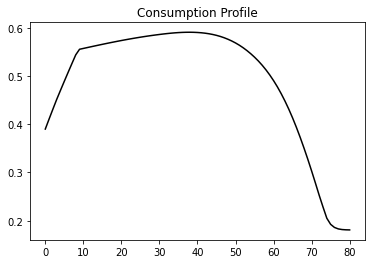

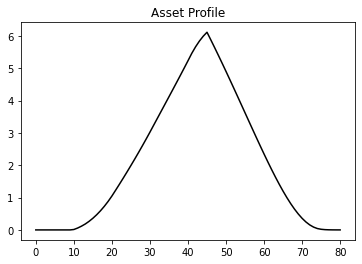

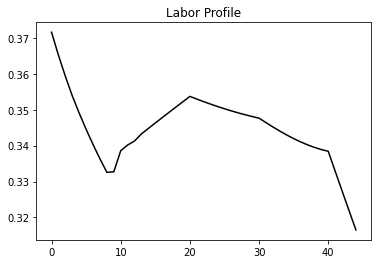

In [8]:
print('')
print('Capital: ' + str(implied_capital))
print('Labor: ' + str(implied_labor))

plt.figure()
plt.plot(np.arange(maxage), con_profile, color='black')
plt.title('Consumption Profile')

plt.figure()
plt.plot(np.arange(maxage), a_profile, color='black')
plt.title('Asset Profile')

plt.figure()
plt.plot(np.arange(ret_age), lab_profile[:ret_age], color='black')
plt.title('Labor Profile')

plt.show()